In [1]:
import torch
import torchaudio
from torchaudio.transforms import MelSpectrogram
from torchaudio.datasets import LIBRISPEECH

In [2]:
SPLITS = ["dev-clean", "train-clean-360"]
DATA_ROOT = "/opt/data/private/linkdom/data/"
dataset = LIBRISPEECH(root = DATA_ROOT, url = SPLITS[0], download = False)
for waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id in dataset:
    print(waveform.shape, sample_rate, utterance.lower(), f"{speaker_id}-{chapter_id}-{utterance_id}")
    break

torch.Size([1, 93680]) 16000 mister quilter is the apostle of the middle classes and we are glad to welcome his gospel 1272-128104-0


torch.Size([584, 80])


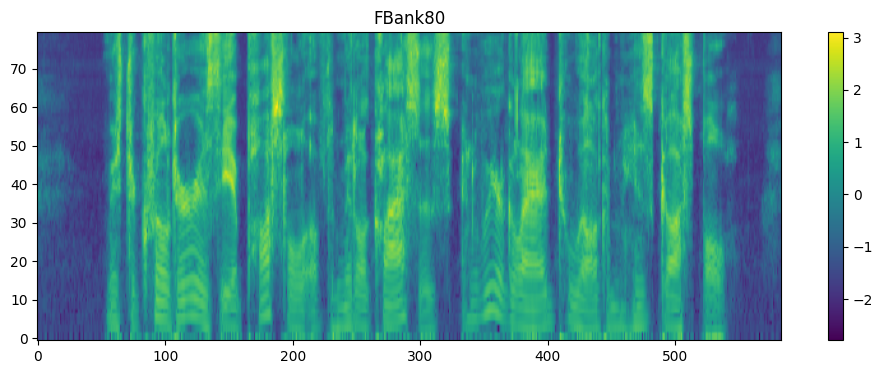

In [3]:
melspec_kwargs = {
    "sample_rate": 16000,
    "n_mels": 80,
    "n_fft": 400,
    "hop_length": 160,
    "center": False,
}
transform = MelSpectrogram(**melspec_kwargs)
fbank = transform(waveform)
fbank = fbank.squeeze(0).transpose(0, 1)
log_offset = 1e-6
fbank = torch.log(fbank + log_offset)
print(fbank.shape)

def cmvn(feature, eps=1e-10):
    mean = feature.mean(dim=0, keepdim=True)
    std = feature.std(dim=0, keepdim=True)
    return (feature - mean) / (std + eps)

fbank = cmvn(fbank)

import matplotlib.pyplot as plt
# plot the fbank features
plt.figure(figsize=(12, 4))
plt.imshow(fbank.t().numpy(), aspect='auto', origin='lower')
plt.colorbar()
plt.title(f'FBank{melspec_kwargs["n_mels"]}')
plt.show()


torch.Size([1, 13, 584])
torch.Size([1, 39, 584])
torch.Size([584, 39])


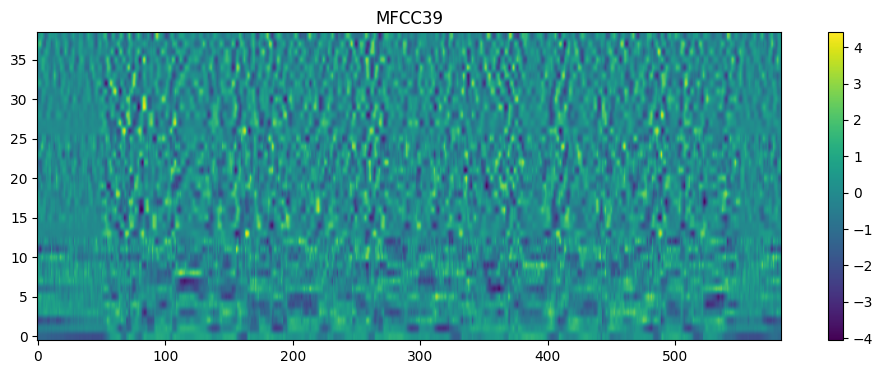

In [8]:
from torchaudio.transforms import MFCC

melkwargs = {
    "n_mels": 23,
    "n_fft": 400,
    "hop_length": 160,
    "center": False,
}

mfcc_kwargs = {
    "sample_rate": 16000,
    "n_mfcc": 13,
    "log_mels": True,
    "melkwargs": melkwargs,
}

transform = MFCC(**mfcc_kwargs)
mfcc = transform(waveform)
# mfcc = mfcc.transpose(1, 2)
print(mfcc.shape)
d1 = torchaudio.functional.compute_deltas(mfcc)
d2 = torchaudio.functional.compute_deltas(d1)
mfcc = torch.cat((mfcc, d1, d2), dim=1)
print(mfcc.shape)

mfcc = mfcc.transpose(1, 2).squeeze(0)
mfcc = cmvn(mfcc)
print(mfcc.shape) 

# plot mfcc features
plt.figure(figsize=(12, 4))
plt.imshow(mfcc.t().numpy(), aspect='auto', origin='lower')
plt.colorbar()
plt.title(f'MFCC{3 * mfcc_kwargs["n_mfcc"]}')
plt.show()

In [5]:
fbank[:2, :5], mfcc[:2, :5]

(tensor([[-1.8702, -1.8708, -1.4855, -1.4855, -1.4126],
         [-1.6297, -1.6298, -1.5275, -1.5275, -1.6069]]),
 tensor([[-1.3134, -0.3859, -2.1056,  0.0543,  0.0888],
         [-1.2539, -0.4383, -2.3567,  0.2614,  0.7212]]))

now there is still a little bit difference between transform and kaldi feature, but they graph is really similar.